In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [3]:
df = pd.read_csv("stock_train.csv")

In [4]:
df.drop(['Total Trade Quantity', 'Turnover (Lacs)'], axis = 1)

,Date,Open,High,Low,Last,Close
0,2018-10-08,208.00,222.25,206.85,216.00,215.15
1,2018-10-05,217.00,218.60,205.90,210.25,209.20
2,2018-10-04,223.50,227.80,216.15,217.25,218.20
3,2018-10-03,230.00,237.50,225.75,226.45,227.60
4,2018-10-01,234.55,234.60,221.05,230.30,230.90
...,...,...,...,...,...,...
1230,2013-10-14,160.85,161.45,157.70,159.30,159.45
1231,2013-10-11,161.15,163.45,159.00,159.80,160.05
1232,2013-10-10,156.00,160.80,155.85,160.30,160.15
1233,2013-10-09,155.70,158.20,154.15,155.30,155.55


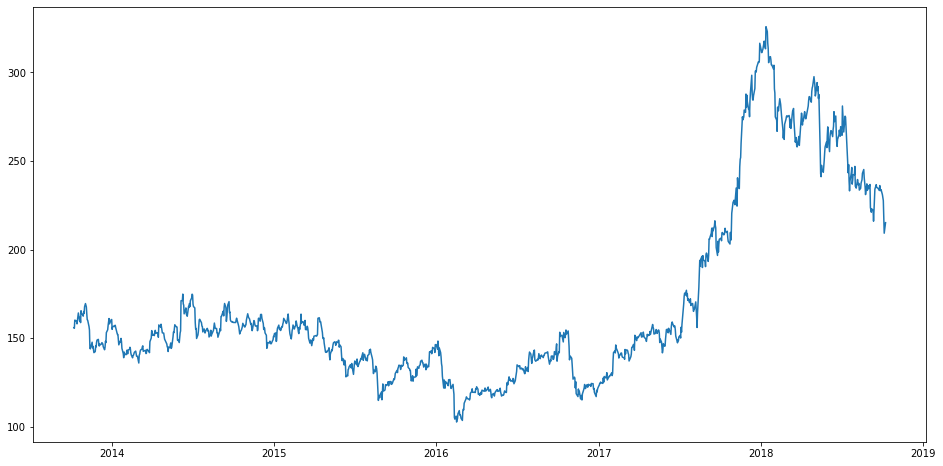

In [5]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

The goal is to ultimately predict a subset of the data using an LSTM. To do this, I'll first filter and normalize the data. 

In [6]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

In [7]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [8]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [10]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=2,batch_size=1,verbose=1)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

Epoch 1/2
927/927 [==============================] - 20s 19ms/step - loss: 7.1458e-04
Epoch 2/2
927/927 [==============================] - 18s 19ms/step - loss: 3.9048e-04


In [11]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("lstm_model_initial.h5")

/Users/mfiedler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


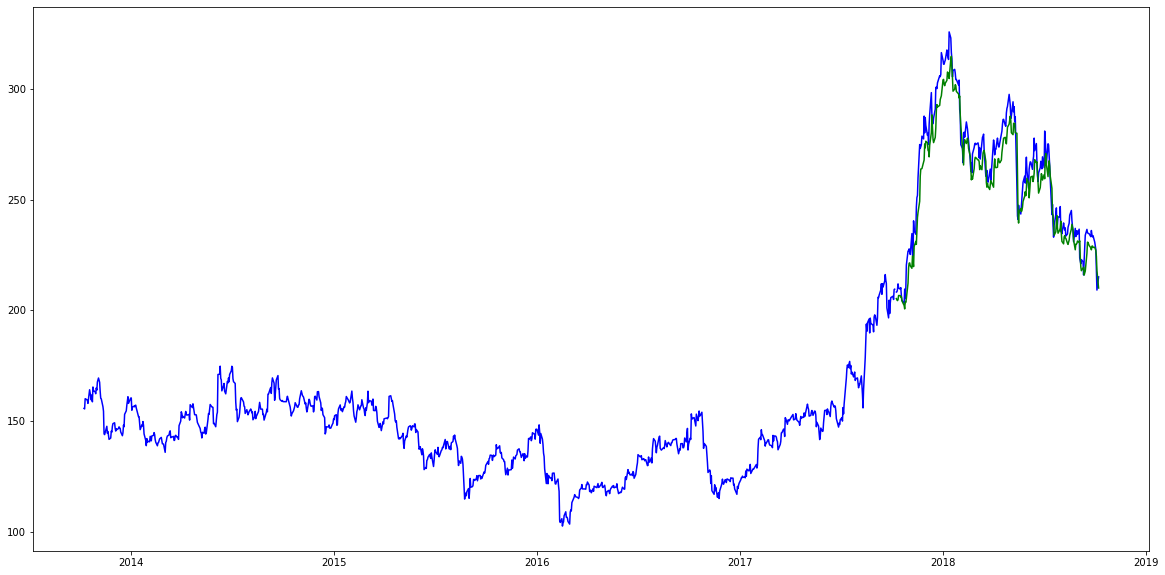

In [24]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"], color = "blue")
plt.plot(valid_data['Close'], color = "blue")
plt.plot(valid_data['Predictions'], color="green")


The predictions turn out great!